@author: Savan Agrawal
@file: play.ipynb
@version: 0.1

# VAE 2D Latent Space Visualization and Interaction with Gym Environment with PyGame

This notebook contains code for visualizing the 2D latent space of a Variational Autoencoder (VAE) using Pygame. The visualization is interactive, allowing the user to select points in the latent space and decode them to generate actions for an agent in a Gym environment. The code includes functions for finding or approximating values in a DataFrame, decoding points from the latent space, and getting colors for the visualization based on latent positions. The main loop handles user input, updates the visualization, and interacts with the Gym environment.

## Importing Required libraries

In [17]:
# Keras and related imports
import keras
from keras import layers, regularizers, backend as K
from keras.layers import Input, Dense, Lambda, LeakyReLU, Dropout
from keras.losses import MSE
from keras.optimizers import SGD
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Standard libraries and data processing
import numpy as np
import pandas as pd
import pickle

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import plotly
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import graphviz

# PyTorch and Tensorflow
import torch
from torch.utils.data import DataLoader
import tensorflow as tf

# sklearn
from sklearn.model_selection import train_test_split

# Others
from matplotlib.colors import ListedColormap
import wget
import pygame
import gymnasium as gym

## Loading and preprocessing Ant dataset

The actions and observations are loaded, reshaped, normalized, concatenated and prepared for training the VAE models.

In [18]:
dataset_path = '../dataset-creator/default-ant/assets/'
actions = np.load(dataset_path + 'actions100knew.npy')
observations = np.load(dataset_path + 'observations100knew.npy')

labels = np.zeros(len(actions))
labels[100000:200000] = 1
labels[200000:300000] = 2
labels[300000:] = 3

actions = actions.reshape((len(actions), np.prod(actions.shape[1:])))
observations = observations.reshape((len(observations), np.prod(observations.shape[1:])))

actions_std = (actions - actions.mean(axis=0)) / actions.std(axis=0)
observations_std = (observations - observations.mean(axis=0)) / observations.std(axis=0)

actions_new = np.concatenate((actions, actions_std), axis=1)
observations_new = np.concatenate((observations, observations_std), axis=1)

actions_observations = np.concatenate((actions_new, observations_new), axis=1)

index = np.arange(0, 400000)

diff_actions = np.zeros(actions.shape)

# Calculate differences in four 100,000-row segments
for i in range(4):
    start_idx = i * 100000
    end_idx = (i + 1) * 100000
    diff_actions[start_idx+1:end_idx] = np.diff(actions[start_idx:end_idx], axis=0)

actions_diff_act = np.concatenate((actions_new, diff_actions), axis=1)

# Loading best trained VAE and reconstructing model

This code loads the trained encoder and decoder models from a previous training run. It then reconstructs the full VAE model using the loaded models.

The trained encoder and decoder models are loaded. The full VAE model is recreated using these components with the original loss functions. This reconstructs the trained VAE for evaluation and inference.

In [19]:
# Constants
original_dim = 24
latent_dim = 2
learning_rate = 0.001  
kl_weight = 0.01 

def sampling(args):
    """Sampling function to sample from the latent space."""
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

def build_encoder(input_shape, latent_dim):
    """Build the encoder network."""
    inputs = Input(shape=input_shape)
    x = Dropout(0.25)(inputs)
    
    # Encode the input data
    for units in [21, 17, 15, 13, 9, 5]:
        x = Dense(units)(x)
        x = LeakyReLU()(x)
    
    z_mean = Dense(latent_dim)(x)
    z_log_sigma = Dense(latent_dim)(x)
    
    z = Lambda(sampling)([z_mean, z_log_sigma])
    
    return Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

def build_decoder(latent_dim, output_shape):
    """Build the decoder network."""
    latent_inputs = Input(shape=(latent_dim,))
    x = latent_inputs
    
    # Decode the latent data
    for units in [5, 9, 13, 17, 21]:
        x = Dense(units, activation='linear')(x)
    
    outputs = Dense(output_shape, activation='linear')(x)
    
    return Model(latent_inputs, outputs, name='decoder')

def vae_reconstruction_loss(y_true, y_pred):
    """Custom reconstruction loss."""
    return MSE(y_true, y_pred) * original_dim

def vae_kl_loss(z_mean, z_log_sigma):
    """Custom KL divergence loss."""
    kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
    return -0.5 * kl_weight * K.sum(kl_loss, axis=-1)

# Split data
x_train, x_test, y_train, y_test, index_train, index_test = train_test_split(actions_diff_act, labels, index, test_size=0.10, random_state=42)

# Loading the models
encoder = load_model("../vae-training/assets/model4/vae_encoder.h5")
decoder = load_model("../vae-training/assets/model4/vae_decoder.h5")

# Recreate the VAE model
inputs_reconstructed = Input(shape=(original_dim,))
outputs_reconstructed = decoder(encoder(inputs_reconstructed)[2])
vae_reconstructed = Model(inputs_reconstructed, outputs_reconstructed, name='reconstructed_vae_mlp')

reconstruction_loss_reconstructed = vae_reconstruction_loss(inputs_reconstructed, outputs_reconstructed)
kl_loss_reconstructed = vae_kl_loss(encoder(inputs_reconstructed)[0], encoder(inputs_reconstructed)[1])
vae_loss_reconstructed = K.mean(reconstruction_loss_reconstructed + kl_loss_reconstructed)

vae_reconstructed.add_loss(vae_loss_reconstructed)
vae_reconstructed.add_metric(reconstruction_loss_reconstructed, name='reconstruction_loss')
vae_reconstructed.add_metric(kl_loss_reconstructed, name='kl_loss')
vae_reconstructed.compile(optimizer=SGD(learning_rate))

### Summary of VAE encoder 

In [20]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 24)]                 0         []                            
                                                                                                  
 dropout_3 (Dropout)         (None, 24)                   0         ['input_13[0][0]']            
                                                                                                  
 dense_45 (Dense)            (None, 21)                   525       ['dropout_3[0][0]']           
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)  (None, 21)                   0         ['dense_45[0][0]']            
                                                                                            

### Summary of VAE decoder

In [21]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_53 (Dense)            (None, 5)                 15        
                                                                 
 dense_54 (Dense)            (None, 9)                 54        
                                                                 
 dense_55 (Dense)            (None, 13)                130       
                                                                 
 dense_56 (Dense)            (None, 17)                238       
                                                                 
 dense_57 (Dense)            (None, 21)                378       
                                                                 
 dense_58 (Dense)            (None, 24)                528 

### Visualizing reconstructed VAE architecture

This code visualizes the architecture of the reconstructed VAE model using the Keras plot_model utility.

The plot_model function is used to generate a graph visualization of the VAE model. Key parameters:
- `show_shapes`: include input/output shapes
- `show_layer_names`: include layer names
- `rankdir`: top-to-bottom layout

This visualization provides a summary of the full VAE model architecture, including the encoder and decoder components.

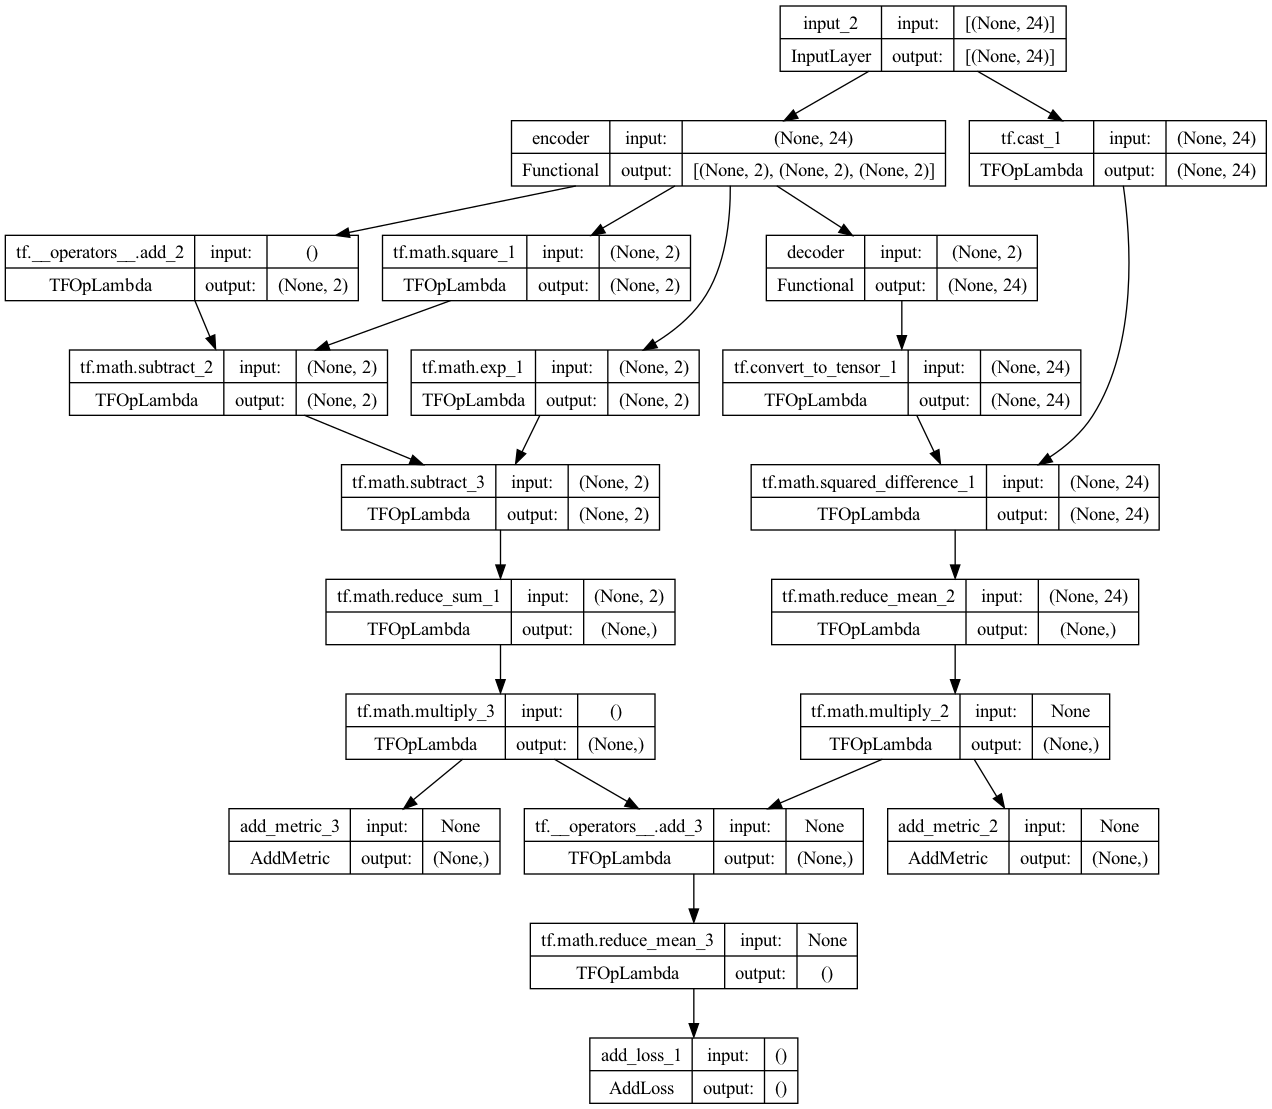

In [22]:
tf.keras.utils.plot_model(
    vae_reconstructed,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

### Encoding test data through trained VAE

This code encodes the test data through the trained VAE encoder to obtain the latent representations.

The test data is encoded into the 2D latent space using the pretrained encoder. The encodings are stored in a DataFrame along with the original labels and indexes. This encoded test data can now be used for visualization and evaluation.

In [23]:
df_x_test = pd.DataFrame(x_test)

model2_df = pd.concat([
    df_x_test,
    pd.DataFrame({
        'y_test': y_test,
        'index_test': index_test
    }, index=df_x_test.index)
], axis=1)

model2_df_sorted = model2_df.sort_values(by='index_test')
x_test_sorted = model2_df_sorted.iloc[:, 0:24].values

x_test_encoded = encoder.predict(x_test_sorted, batch_size=100)

df_x_test_enc = pd.DataFrame(x_test_encoded[2])

df_encoded = pd.concat([
    df_x_test_enc,
    pd.DataFrame({
        'y_test': model2_df_sorted['y_test'].values,
        'index_test': model2_df_sorted['index_test'].values
    }, index=df_x_test_enc.index)
], axis=1)

400/400 [==============================] - 0s 345us/step


# Interactive latent space control of Ant environment

This code creates an interactive PyGame visualization of the VAE latent space to control the Ant environment.

### Functions to decode latent space paths

This defines two functions to decode paths drawn on the latent space visualization into sequences of actions.

- `find_or_approximate` gets closest encoded point.
- `decode_from_points` uses this to extract and decode a sequence of points along the path into a sequence of actions.

In [24]:
def find_or_approximate(df, col, value1, value2, third_col_value):
    value1 = (value1 / WIDTH) * 2 - 1
    value2 = (value2 / WIDTH) * 2 - 1

    # Filter based on third column's value
    if third_col_value is not None:
        df = df[df['y_test'] == third_col_value]

    # Calculate the absolute difference for both values in the filtered rows
    df['diff'] = (df[col[0]] - value1).abs() + (df[col[1]] - value2).abs()
    
    # Get the row with the minimum sum of absolute differences
    min_diff_row = df.loc[df['diff'].idxmin()]
    
    return min_diff_row.drop('diff')

def decode_from_points(path_points):
    a = find_or_approximate(df_encoded, [0, 1], path_points[0][0], path_points[0][1], None)
    b = find_or_approximate(df_encoded, [0, 1], path_points[1][0], path_points[1][1], a['y_test'])

    # Extract all rows between a and b with the same y_test value
    start_idx, end_idx = sorted([a.name, b.name])  
    in_between_rows = df_encoded.loc[start_idx:end_idx]
    in_between_rows = in_between_rows[in_between_rows['y_test'] == a['y_test']]

    x_y = np.column_stack((in_between_rows[0], in_between_rows[1]))
    decoded_values = decoder.predict(x_y, batch_size=100)

    return decoded_values[::20]


Clicking two points decodes a path to actions which are executed in the Ant environment. This allows interactively controlling the simulated agent.

In [25]:
env = gym.make("Ant-v4", render_mode="human")
observation, info = env.reset()

# Initialize pygame
pygame.init()

# Define screen dimensions
WIDTH, HEIGHT = 800, 600

# Create a screen and a clock
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("VAE 2D Latent Space")
clock = pygame.time.Clock()

font = pygame.font.SysFont(None, 25)  # Font for displaying text

def decode_from_latent_space(latent_x, latent_y):
    action = decoder.predict(np.column_stack((latent_x, latent_y)))
    return action[0][0:8]

def get_color_from_latent_position(x, y):
    return (int(x * 255), int(y * 255), 200)  # Example RGB value

# Main loop
running = True
drawing_path = False
path_points = []
action = []


first_point = None
last_point = None

while running:
    screen.fill((255, 255, 255))

    for x in range(WIDTH):
        for y in range(HEIGHT):
            color = get_color_from_latent_position(x/WIDTH, y/HEIGHT)
            screen.set_at((x, y), color)
    
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_q:
                running = False

        if event.type == pygame.MOUSEBUTTONDOWN:
            if first_point is None:
                first_point = event.pos
            elif last_point is None:
                last_point = event.pos
                # Process the points from first_point to last_point
                path_points = [first_point, last_point]
                # print(path_points)
                decoded_values = decode_from_points(path_points)
                print(len(decoded_values))
                for i in range(len(decoded_values)):
                    action = decoded_values[i][0:8]
                    _, reward, terminated, truncated, info = env.step(action)

                    # if terminated or truncated:
                    #     observation, info = env.reset()
                    # if i > 1000:
                    #     break

                first_point = last_point
                last_point = None
            else:
                pass
        
    # Display feedback about the action 
    feedback_text = font.render(f"Last Action: {action}", True, (0, 0, 0))
    screen.blit(feedback_text, (10, 10))
    
    pygame.display.flip()
    clock.tick(60)

pygame.quit()
env.close()


79/79 [==============================] - 0s 307us/step


/var/folders/w2/w5nbpgdx6x938lygn2q2g4b00000gn/T/ipykernel_4701/980328888.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff'] = (df[col[0]] - value1).abs() + (df[col[1]] - value2).abs()


392
